# Exploring the Data

This notebook explores how to import data from the LFW data set. It uses a small sample of the full data set (pictures of George W. Bush).
* [Link to LFW page](http://vis-www.cs.umass.edu/lfw/)
* [Link to GWB data](http://vis-www.cs.umass.edu/lfw/lfw-bush.tgz)
* [Link to lfw-fuel](https://github.com/dribnet/lfw_fuel/blob/master/lfw_fuel/lfw.py) (extremely useful for understanding how to extract data from the images)
* [Link to run-lfw](https://github.com/dribnet/lfw_fuel/blob/master/example/run-lfw.py) (builds a neural network using keras)

In [20]:
# numerics
import numpy as np
import itertools

# images
from scipy.misc import *
#imresize, imread, imshow
import matplotlib.pyplot as plt

# dealing with tar files
import tarfile, gzip

# extracting data about faces/people
import csv

# nice stuff
import os, re
from pprint import pprint

In [21]:
%matplotlib inline

Load training and testing data sets (text files provided by LFW):

In [22]:
print("Building test/train lists...")

# skip row 0, which is the header
with open('data/pairsDevTrain.txt', 'r') as csvfile:
    trainrows = list(csv.reader(csvfile, delimiter='\t'))[1:]
with open('data/pairsDevTest.txt', 'r') as csvfile:
    testrows = list(csv.reader(csvfile, delimiter='\t'))[1:]

print("Done.")

Building test/train lists...
Done.


In [23]:
print("Length of training data set: %d"%(len(trainrows)))
pprint(trainrows[:10])

Length of training data set: 2200
[['Aaron_Peirsol', '1', '2'],
 ['Aaron_Peirsol', '3', '4'],
 ['Aaron_Sorkin', '1', '2'],
 ['Abdel_Nasser_Assidi', '1', '2'],
 ['Abdullah', '1', '3'],
 ['Abdullah', '2', '4'],
 ['Abdullah_al-Attiyah', '1', '3'],
 ['Abdullah_al-Attiyah', '2', '3'],
 ['Abel_Pacheco', '1', '4'],
 ['Abel_Pacheco', '3', '4']]


In [24]:
print("Length of test data set: %d"%(len(testrows)))
pprint(testrows[:10])

Length of test data set: 1000
[['Abdullah_Gul', '13', '14'],
 ['Abdullah_Gul', '13', '16'],
 ['Abdullatif_Sener', '1', '2'],
 ['Adel_Al-Jubeir', '1', '3'],
 ['Al_Pacino', '1', '2'],
 ['Alan_Greenspan', '1', '5'],
 ['Albert_Costa', '2', '6'],
 ['Albert_Costa', '4', '6'],
 ['Albert_Costa', '5', '6'],
 ['Alejandro_Atchugarry', '1', '2']]


This file consists of two parts: same, and different. The first set of rows are "same" and the second set of rows are "different".

In [25]:
print("Example of a 'same' row:")
print(testrows[0])

print()

print("Example of a 'different' row:")
for row in testrows:
    if(len(row)!=3):
        print(row)
        break

Example of a 'same' row:
['Abdullah_Gul', '13', '14']

Example of a 'different' row:
['AJ_Lamas', '1', 'Zach_Safrin', '1']


Here is how to load an image from a compressed .tgz file:

In [26]:
with open('data/lfw-names.txt', 'r') as csvfile:
    allrows = list(csv.reader(csvfile, delimiter='\t'))[1:]

for row in allrows:
    if('Bush' in row[0]):
        print(row)

['Columba_Bush', '1']
['George_HW_Bush', '13']
['George_P_Bush', '2']
['George_W_Bush', '530']
['Jeb_Bush', '12']
['Laura_Bush', '41']
['Noelle_Bush', '4']


In [27]:
# images of people are stored in the tar files in the following format:
# 
# <basename>/<name>/<name>_<number 04d>.jpg
#
# where number comes from the second or third column in the text file

def load_image(tgz_file, basename, name, number):
    filename = "{0}/{1}/{1}_{2:04d}.jpg".format(basename, name, int(number))
    tgz = tarfile.open(tgz_file)
    return imread(tgz.extractfile(filename))

In [28]:
tgz = "data/lfw-bush.tgz"
z = load_image(tgz,"lfw","George_W_Bush",5)

Shape of image: W x H x RGB
(250, 250, 3)


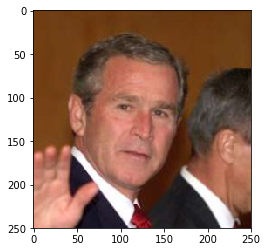

In [29]:
print("Shape of image: W x H x RGB")
print(np.shape(z))
plt.imshow(np.uint8(z))

Now turn the image into numbers to feed to the neural network:

In [30]:
def extract_features(z):
    features = np.array([z[:,:,0],z[:,:,1],z[:,:,2]])
    return features

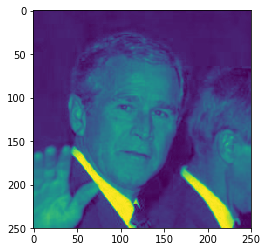

In [31]:
plt.imshow(z[:,:,2])

In [32]:
features = extract_features(z)
print(features)
print(np.shape(features))

[[[112 114 115 ..., 100 100 100]
  [112 114 115 ..., 101 101 101]
  [112 114 114 ..., 101 101 101]
  ..., 
  [231 231 231 ...,  44  46  46]
  [231 233 234 ...,  46  46  46]
  [232 234 235 ...,  46  46  46]]

 [[ 60  61  62 ...,  55  55  55]
  [ 60  61  62 ...,  56  56  56]
  [ 60  61  61 ...,  56  56  56]
  ..., 
  [155 155 154 ...,   7   9   9]
  [155 157 157 ...,   9   9   9]
  [154 156 157 ...,   9   9   9]]

 [[ 20  19  20 ...,  14  14  14]
  [ 20  19  20 ...,  15  15  15]
  [ 20  19  19 ...,  15  15  15]
  ..., 
  [132 132 134 ...,   1   3   3]
  [132 134 137 ...,   3   3   3]
  [132 134 137 ...,   3   3   3]]]
(3, 250, 250)


Load multiple images into a vector of data to feed the neural network:

In [33]:
tgz = "data/lfw-bush.tgz"

# start with list
data_set = []

for i in range(1,21):
    z = load_image(tgz,"lfw","George_W_Bush",i)
    features = extract_features(z)
    data_set.append(features)

# turn list into numpy array
data_set = np.array(data_set)


In [34]:
print(np.shape(data_set))

(20, 3, 250, 250)


Now that we have the image inputs, we need to get the training outputs.